# Мобильные приложения — Выделение групп пользователей на основе поведения 

**Описание данных:**

*Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений. В датасете содержатся данные пользователей, впервые совершивших действия в
приложении после 7 октября 2019 года.*

Датасет **mobile_dataset.csv** содержит колонки:

- event.time  — время совершения
- event.name  — название события
- user.id  — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:
- userId  — идентификатор пользователя
- source  — источник, с которого пользователь установил приложение

*Расшифровки событий:*
- advert_open  — открытие карточки объявления
- photos_show  — просмотр фотографий в объявлении
- tips_show  — пользователь увидел рекомендованные объявления
- tips_click  — пользователь кликнул по рекомендованному объявлению
- contacts_show  и  show_contacts  — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- contacts_call  — пользователь позвонил по номеру телефона на карточке объявления
- map  — пользователь открыл карту размещенных объявлений
- search_1  —  search_7  — разные события, связанные с поиском по сайту
- favorites_add  — добавление объявления в избранное

**Наши цели:**

- выделить сегменты пользователей для управления вовлеченностью (адаптировать приложение под целевую и смежные аудитории)
- получить на основе сегментации гипотезы о том как можно было бы улучшить приложение с точки зрения пользовательского  опыта

**План работы**

1) Выгрузка, ознакомление с данными

2) Предобработка данных

2.1 Приведения наименований к змеиному регистру

2.2 Приведение типов данных к необходимому формату

2.3  Обработка событий и проверка на дубликаты

3) Исследовательский анализ данных общего поведения пользователей

3.1 Выделение сессий пользователей 

3.2 Retention rate

3.3 Время, проведённое в приложении

3.4 Частота действий

3.5 Конверсия в целевое действие — просмотр контактов

4) Сегментация пользователей по времени, проведенному в приложении 
(Пользователи, которые проводят мало времени в приложении и пользователи, которые проводят много времени в приложении)

4.1 Проверка на пересечение пользователей в группах

4.2 Проверка размеров выборок

4.3 Пользователи какой группы часто возвращаются в мобильное приложение (retention rate)

4.4 Пользователи какой группы часто совершают целевое событие (конверсия в просмотры контактов)

5) Проверка гипотез

5.1 Пользователи, установившие приложение по ссылке из yandex, и пользователи, установившие приложение по ссылке из google, демонстрируют разную конверсию в просмотры контактов

5.2 Пользователи, которые проводят мало времени в приложении и пользователи, которые проводят много времени в приложении не различаются по частоте действий

6) Выводы и рекомендации

## Выгрузка, ознакомление с данными

In [1]:
#загрузим библиотеки

import pandas as pd
import seaborn as sns

from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import plotly.express as px

from scipy import stats as st
import numpy as np
import math as mth

%config InlineBackend.figure_format = 'retina'

import matplotlib 
matplotlib.style.use('seaborn-pastel')

In [2]:
#прочитаем датасеты

try:
    mobile_sourсes = pd.read_csv('/datasets/mobile_soures.csv')
    mobile_dataset = pd.read_csv('/datasets/mobile_dataset.csv')
except:
    mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
    mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [3]:
#напишем функцию для первоначального анализа, ознакомимся с данными и проверим на полные дубликаты и пропуски

def info(df):
    display(df.head())
    print(df.isna().sum())
    print(df.duplicated().sum())
    print(df.info())

In [4]:
info(mobile_sourсes)

userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

userId    0
source    0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
None


In [5]:
info(mobile_dataset)

event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

event.time    0
event.name    0
user.id       0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None


Таким образом, у нас есть информация о 4293 пользователях, с указанием источника привлечения, данными о совершенных событиях и о времени их совершения. Полных дубликатов нет, пропусков нет.

## Предобработка данных

### Приведение наименований к змеиному регистру

In [6]:
#поменяем названия столбцов

mobile_sourсes.rename(columns = {'userId':'user_id'},  inplace = True)

mobile_dataset.columns = [x.replace('.', '_') for x in mobile_dataset.columns]

### Приведение типов данных к необходимому формату

In [7]:
#преобразуем тип данных о времени

mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])

### Обработка событий и проверка на дубликаты

In [8]:
#заменим события show_contacts на contacts_show, они идентичны

mobile_dataset['event_name'] = mobile_dataset['event_name'].replace('show_contacts', 'contacts_show')

#объединим события search_1 — search_7 в одно search, они тоже схожи, возможно это поиск с различными фильтрами

#создадим список 

search_list = ['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7']

#заменим значения

mobile_dataset.loc[mobile_dataset['event_name'].isin(search_list), 'event_name'] = 'search'

#еще раз проверим на дубликаты

mobile_dataset.duplicated().sum()

0

Данные готовы к анализу.

## Исследовательский анализ данных общего поведения пользователей

In [9]:
#посмотрим данными за какой период мы располагаем

print(mobile_dataset['event_time'].min())
print(mobile_dataset['event_time'].max())
print(mobile_dataset['event_time'].max() - mobile_dataset['event_time'].min())

2019-10-07 00:00:00.431357
2019-11-03 23:58:12.532487
27 days 23:58:12.101130


Итак, у нас 4 недели с 7 октября 2019г. по 3 ноября 2019г.

### Выделение сессий пользователей 

Время, в течение которого при отсутствии активности пользователя сессия считается завершенной, по умолчанию обычно равно 30 минутам.

Мы примем, что если между событиями прошло более чем 40 минут, то их относят к разным сессиям.

In [10]:
#для выделения сессий отсортируем датасет по user_id и event_time

mobile_dataset = mobile_dataset.sort_values(['user_id', 'event_time']) 

g = (mobile_dataset.groupby('user_id')['event_time'].diff() > pd.Timedelta('40Min')).cumsum()

#добавим столбец с номером сессии

mobile_dataset['session_id'] = mobile_dataset.groupby(['user_id', g], sort=False).ngroup() + 1
mobile_dataset

event_time     event_name  \
805   2019-10-07 13:39:45.989359      tips_show   
806   2019-10-07 13:40:31.052909      tips_show   
809   2019-10-07 13:41:05.722489      tips_show   
820   2019-10-07 13:43:20.735461      tips_show   
830   2019-10-07 13:45:30.917502      tips_show   
...                          ...            ...   
72584 2019-11-03 15:51:23.959572      tips_show   
72589 2019-11-03 15:51:57.899997  contacts_show   
72684 2019-11-03 16:07:40.932077      tips_show   
72688 2019-11-03 16:08:18.202734      tips_show   
72689 2019-11-03 16:08:25.388712      tips_show   

                                    user_id  session_id  
805    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
806    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
809    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
820    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
830    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
...                                     ...         ...  
72584  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10029  
72589  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10029  
72684  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10029  
72688  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10029  
72689  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10029  

[74197 rows x 4 columns]

### Retention rate

In [11]:
#найдем дату и время первого посещения для каждого пользователя

first_date = mobile_dataset.groupby('user_id').agg({'event_time':'first'}).reset_index()
first_date.rename(columns = {'event_time':'first_date_time'},  inplace = True)

#добавим столбец с датой первого посещения

first_date['first_date'] = first_date['first_date_time'].dt.date

In [12]:
#присоедим first_date к датасету по столбцу user_id

mobile_dataset = mobile_dataset.merge(
    first_date[['user_id', 'first_date_time', 'first_date']], on='user_id', how='left'
)

In [13]:
#найдем дату и время начала всех сессий для каждого пользователя

session_start = mobile_dataset.groupby(['user_id', 'session_id']).agg({'event_time':'first'}).reset_index()
session_start.rename(columns = {'event_time':'session_start'},  inplace = True)

In [14]:
#напишем функцию для расчёта удержания

def get_retention(
    mobile_dataset, session_start, observation_date, horizon_days, ignore_horizon=False
):
    #исключим пользователей, не «доживших» до горизонта анализа
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = mobile_dataset.query('first_date <= @last_suitable_acquisition_date')
    
    #присоедим session_start к датасету по столбцу session_id

    result_raw = result_raw.merge(
        session_start[['session_id', 'session_start']], on='session_id', how='left'
    )
      
    #вычислим лайфтайм каждой сессии в днях

    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_date_time']
    ).dt.days

    #построим таблицу удержания

    result_grouped = result_raw.pivot_table(
        index=['first_date'], columns='lifetime', values='user_id', aggfunc='nunique'
    )

    #вычислим размеры когорт

    cohort_sizes = (
        result_raw.groupby('first_date')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )

    #объединим размеры когорт и таблицу удержания

    result_grouped = cohort_sizes.merge(
        result_grouped, on='first_date', how='left'
    ).fillna(0)

    #поделим данные таблицы удержания на размеры когорт

    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    #исключим все лайфтаймы, превышающие горизонт анализа
    
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    #восстановим столбец с размерами когорт
    
    result_grouped['cohort_size'] = cohort_sizes

    #возвратим таблицу удержания и сырые данные
    
    return result_raw, result_grouped

#получим сырые данные и готовую таблицу
#проигнорируем горизонт анализа

retention_raw, retention = get_retention(
    mobile_dataset, session_start, datetime(2019, 11, 4).date(), 7, ignore_horizon=True
)
retention

cohort_size    0         1         2         3         4  \
first_date                                                             
2019-10-07          204  1.0  0.117647  0.093137  0.107843  0.053922   
2019-10-08          167  1.0  0.161677  0.125749  0.053892  0.041916   
2019-10-09          176  1.0  0.073864  0.062500  0.056818  0.068182   
2019-10-10          174  1.0  0.086207  0.103448  0.080460  0.091954   
2019-10-11          136  1.0  0.088235  0.117647  0.095588  0.088235   
2019-10-12          125  1.0  0.120000  0.160000  0.056000  0.064000   
2019-10-13          148  1.0  0.128378  0.067568  0.054054  0.067568   
2019-10-14          185  1.0  0.113514  0.102703  0.102703  0.081081   
2019-10-15          186  1.0  0.134409  0.086022  0.075269  0.053763   
2019-10-16          166  1.0  0.126506  0.072289  0.030120  0.048193   
2019-10-17          170  1.0  0.141176  0.129412  0.088235  0.088235   
2019-10-18          156  1.0  0.083333  0.096154  0.096154  0.057692   
2019-10-19          159  1.0  0.094340  0.113208  0.069182  0.025157   
2019-10-20          144  1.0  0.104167  0.076389  0.048611  0.069444   
2019-10-21          161  1.0  0.093168  0.086957  0.099379  0.037267   
2019-10-22          157  1.0  0.108280  0.082803  0.050955  0.038217   
2019-10-23          189  1.0  0.095238  0.079365  0.074074  0.052910   
2019-10-24          162  1.0  0.098765  0.074074  0.049383  0.061728   
2019-10-25          147  1.0  0.088435  0.095238  0.102041  0.095238   
2019-10-26          139  1.0  0.143885  0.064748  0.071942  0.086331   
2019-10-27          139  1.0  0.071942  0.071942  0.071942  0.079137   
2019-10-28          158  1.0  0.094937  0.094937  0.056962  0.056962   
2019-10-29          135  1.0  0.170370  0.118519  0.096296  0.051852   
2019-10-30          134  1.0  0.126866  0.074627  0.059701  0.022388   
2019-10-31          132  1.0  0.083333  0.045455  0.022727  0.000000   
2019-11-01          112  1.0  0.098214  0.026786  0.000000  0.000000   
2019-11-02           97  1.0  0.103093  0.000000  0.000000  0.000000   
2019-11-03          135  1.0  0.000000  0.000000  0.000000  0.000000   

                   5         6  
first_date                      
2019-10-07  0.034314  0.058824  
2019-10-08  0.065868  0.053892  
2019-10-09  0.068182  0.056818  
2019-10-10  0.080460  0.068966  
2019-10-11  0.073529  0.066176  
2019-10-12  0.088000  0.080000  
2019-10-13  0.054054  0.054054  
2019-10-14  0.070270  0.048649  
2019-10-15  0.053763  0.080645  
2019-10-16  0.060241  0.042169  
2019-10-17  0.094118  0.094118  
2019-10-18  0.064103  0.064103  
2019-10-19  0.056604  0.062893  
2019-10-20  0.062500  0.041667  
2019-10-21  0.037267  0.049689  
2019-10-22  0.057325  0.057325  
2019-10-23  0.052910  0.047619  
2019-10-24  0.061728  0.067901  
2019-10-25  0.061224  0.068027  
2019-10-26  0.057554  0.071942  
2019-10-27  0.086331  0.064748  
2019-10-28  0.012658  0.025316  
2019-10-29  0.022222  0.000000  
2019-10-30  0.000000  0.000000  
2019-10-31  0.000000  0.000000  
2019-11-01  0.000000  0.000000  
2019-11-02  0.000000  0.000000  
2019-11-03  0.000000  0.000000

Установим момент анализа на 4 ноября 2019г., зададим горизонт анализа в 7 дней

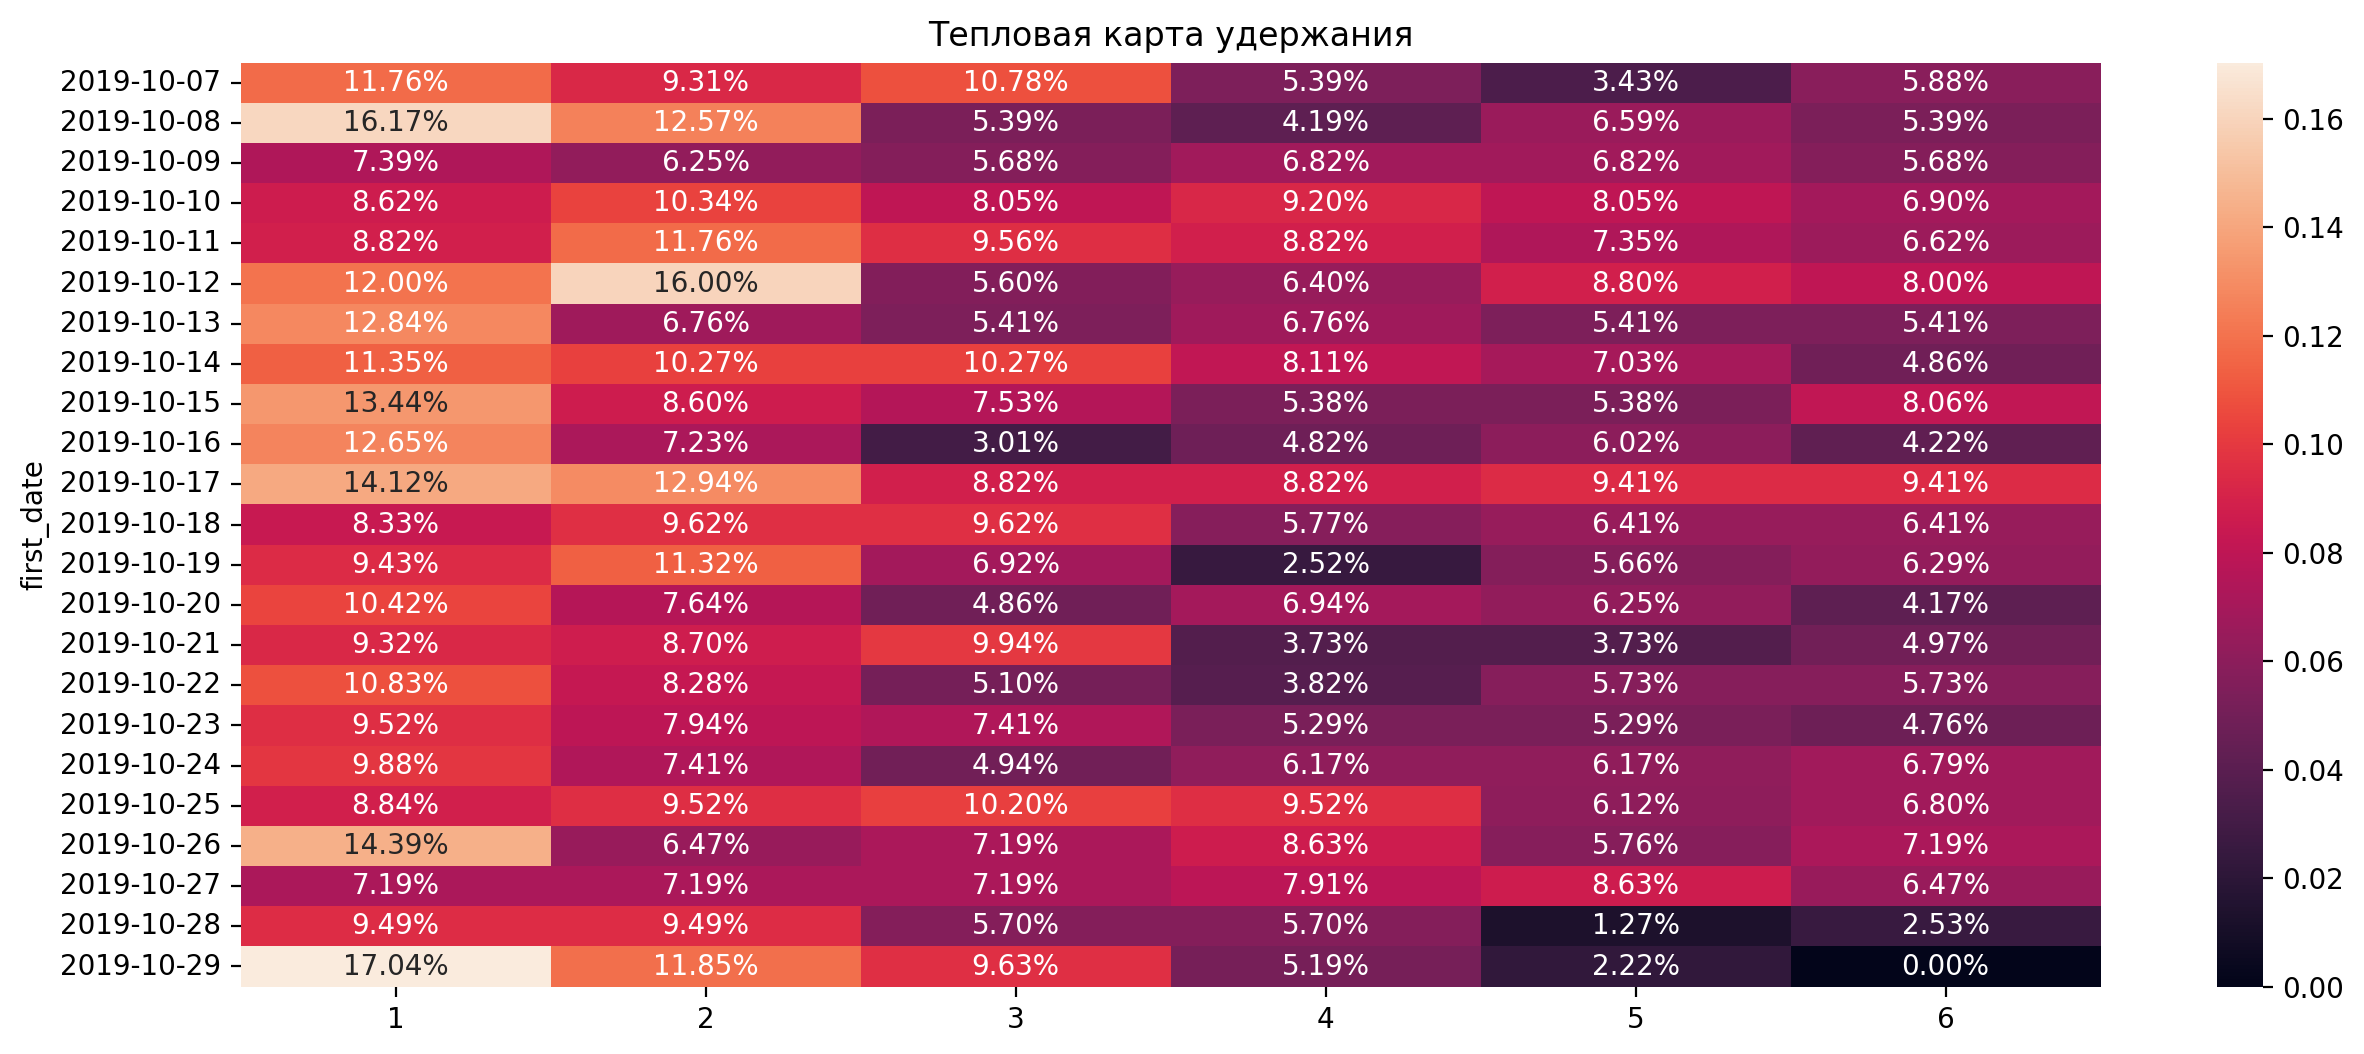

In [15]:
#построим хитмэп с учётом горизонта анализа

retention_raw, retention = get_retention(
    mobile_dataset, session_start, datetime(2019, 11, 4).date(), 7
)

plt.figure(figsize = (15, 6))  
sns.heatmap(retention.drop(columns = ['cohort_size', 0]), #удаляем размеры когорт и 0 столбец
            annot = True,  
            fmt = '.2%'  
           )
plt.title('Тепловая карта удержания')  
plt.show()

По тепловой карте удержания за 3 недели с горизонтом анализа в 7 дней, мы видим максимально 17% и 16% удержание на второй и третий день и минимально 7,2% и 6,2%. Удержание на седьмой день составляет около 5-6%.

### Время, проведённое в приложении

In [16]:
#рассчитаем время каждой сессии в минутах

session = mobile_dataset.groupby(['user_id', 'session_id']).agg({'event_time':['first', 'last']}).reset_index() #находим время начала и окончания сессии
session.columns = [x[1] if x[1] else x[0] for x in session.columns] 
session.rename(columns = {'first':'session_start','last':'session_end' },  inplace = True) 

session['session_duration'] = (session['session_end'] - session['session_start']).dt.total_seconds() / 60 #находим длительность сессии в минутах
session

user_id  session_id  \
0      0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1   
1      0001b1d5-b74a-4cbf-aeb0-7df5947bf349           2   
2      0001b1d5-b74a-4cbf-aeb0-7df5947bf349           3   
3      0001b1d5-b74a-4cbf-aeb0-7df5947bf349           4   
4      00157779-810c-4498-9e05-a1e9e3cedf93           5   
...                                     ...         ...   
10024  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10025   
10025  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10026   
10026  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10027   
10027  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10028   
10028  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10029   

                   session_start                session_end  session_duration  
0     2019-10-07 13:39:45.989359 2019-10-07 13:49:41.716617          9.928788  
1     2019-10-09 18:33:55.577963 2019-10-09 18:42:22.963948          8.456433  
2     2019-10-21 19:52:30.778932 2019-10-21 20:07:30.051028         14.987868  
3     2019-10-22 11:18:14.635436 2019-10-22 11:30:52.807203         12.636196  
4     2019-10-19 21:34:33.849769 2019-10-19 21:59:54.637098         25.346455  
...                          ...                        ...               ...  
10024 2019-11-02 01:16:48.947231 2019-11-02 01:16:48.947231          0.000000  
10025 2019-11-02 18:01:27.094834 2019-11-02 18:17:41.386651         16.238197  
10026 2019-11-02 19:25:53.794029 2019-11-02 19:30:50.471310          4.944621  
10027 2019-11-03 14:32:55.956301 2019-11-03 14:48:44.263356         15.805118  
10028 2019-11-03 15:36:01.007440 2019-11-03 16:08:25.388712         32.406355  

[10029 rows x 5 columns]

In [17]:
#посмотрим минимальное, максимальное, среднее и суммарное время сессий по каждому пользователю и количество сессий на пользователя

session_duration = session.groupby('user_id').agg({'session_duration':['max', 'min', 'mean', 'sum'], 'session_id':'count'}).droplevel(0, axis=1)
session_duration

max        min       mean  \
user_id                                                                  
0001b1d5-b74a-4cbf-aeb0-7df5947bf349   14.987868   8.456433  11.502321   
00157779-810c-4498-9e05-a1e9e3cedf93   76.201974   0.000000  32.706135   
00463033-5717-4bf1-91b4-09183923b9df   24.707917  24.707917  24.707917   
004690c3-5a84-4bb7-a8af-e0c8f8fca64e   39.319584   0.298441  18.456552   
00551e79-152e-4441-9cf7-565d7eb04090    9.269017   0.000000   3.109247   
...                                          ...        ...        ...   
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07   29.383983  20.036432  24.710207   
ffc01466-fdb1-4460-ae94-e800f52eb136    0.868974   0.868974   0.868974   
ffcf50d9-293c-4254-8243-4890b030b238    1.339636   1.339636   1.339636   
ffe68f10-e48e-470e-be9b-eeb93128ff1a   15.897910  10.387269  12.958839   
fffb9e79-b927-4dbb-9b48-7fd09b23a62b  120.118051   0.000000  18.306884   

                                             sum  count  
user_id                                                  
0001b1d5-b74a-4cbf-aeb0-7df5947bf349   46.009285      4  
00157779-810c-4498-9e05-a1e9e3cedf93  196.236810      6  
00463033-5717-4bf1-91b4-09183923b9df   24.707917      1  
004690c3-5a84-4bb7-a8af-e0c8f8fca64e  110.739310      6  
00551e79-152e-4441-9cf7-565d7eb04090    9.327742      3  
...                                          ...    ...  
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07   49.420415      2  
ffc01466-fdb1-4460-ae94-e800f52eb136    0.868974      1  
ffcf50d9-293c-4254-8243-4890b030b238    1.339636      1  
ffe68f10-e48e-470e-be9b-eeb93128ff1a   38.876517      3  
fffb9e79-b927-4dbb-9b48-7fd09b23a62b  549.206525     30  

[4293 rows x 5 columns]

In [18]:
session_duration.describe(percentiles=[0.05, 1/4, 1/2, 0.75, 0.90, 0.95, 0.99])

max          min         mean          sum        count
count  4293.000000  4293.000000  4293.000000  4293.000000  4293.000000
mean     23.112028    11.330577    15.887202    33.833468     2.336129
std      28.632306    17.731107    18.562731    70.052412     3.354413
min       0.000000     0.000000     0.000000     0.000000     1.000000
5%        0.842736     0.000000     0.522943     0.881281     1.000000
25%       5.718168     0.024618     4.282177     6.242040     1.000000
50%      13.905372     4.931174    10.002819    15.774810     1.000000
75%      30.453831    14.875371    21.015261    36.229060     2.000000
90%      52.997996    31.416929    36.858785    72.793546     4.000000
95%      74.441401    44.715765    48.696956   121.909563     6.000000
99%     129.599011    81.387237    86.226021   285.297039    16.000000
max     367.597290   222.978051   222.978051  1890.179354    93.000000

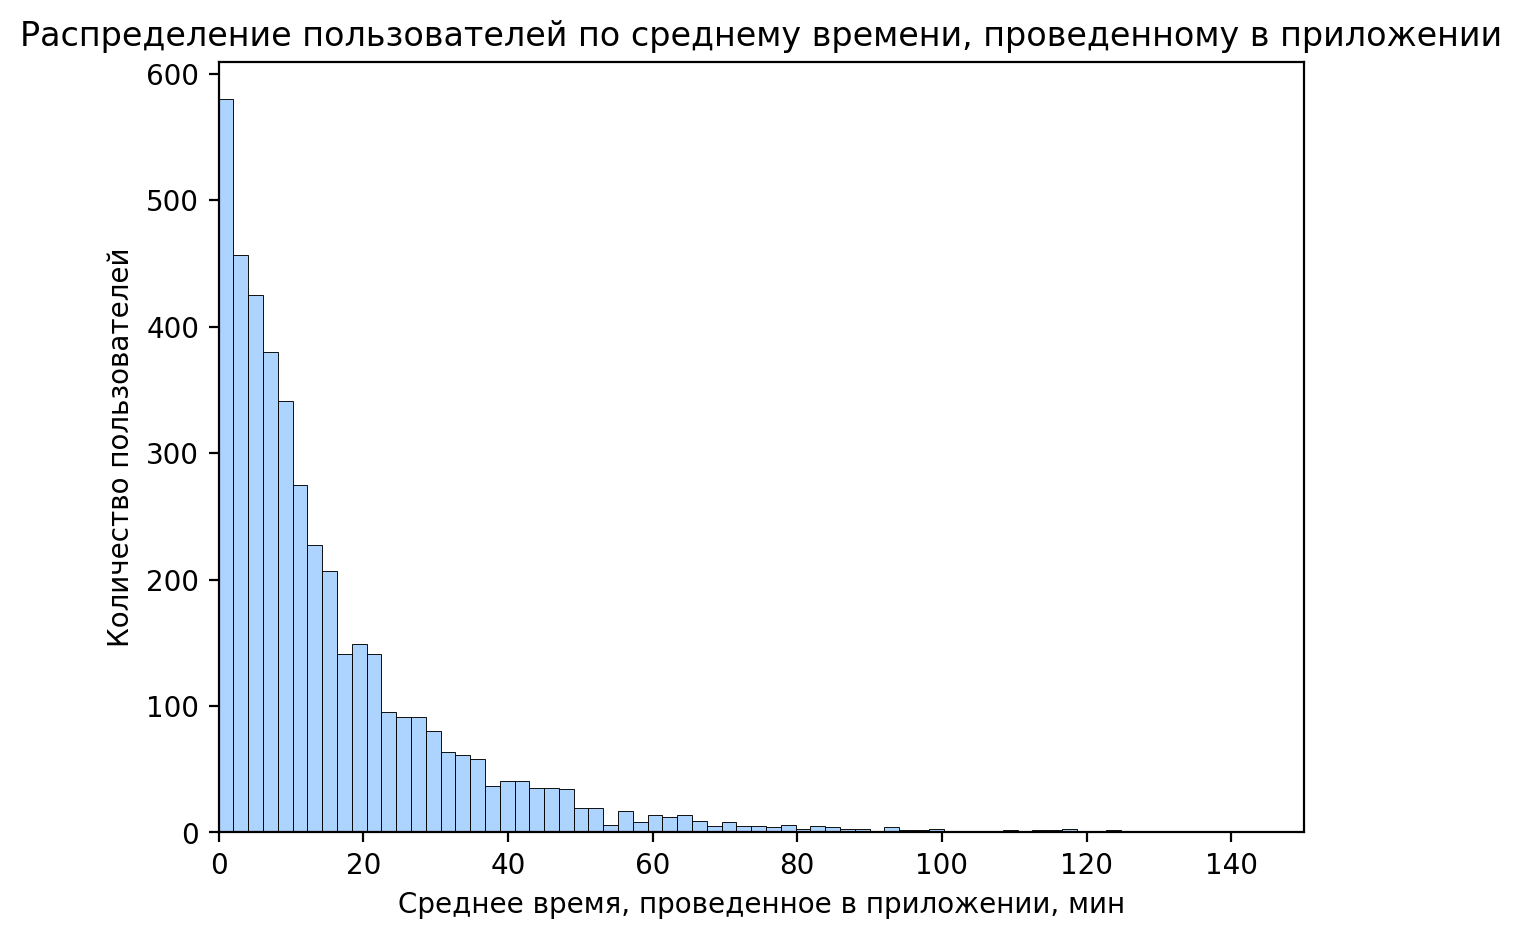

In [19]:
#построим график распределения пользователей по среднему времени, проведенному в приложении

plt.figure(figsize = (7,5))
sns.histplot(x='mean', data=session_duration)
plt.xlabel('Среднее время, проведенное в приложении, мин')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по среднему времени, проведенному в приложении')
plt.xlim(0, 150)
plt.show()

In [20]:
#найдем количество нулевых сессий

zero = session.query('session_duration == 0')

#посмотрим какие события происходили в нулевые сесии

pd.options.mode.chained_assignment = None

zero.rename(columns = {'session_start':'event_time'},  inplace = True)

zero_action = zero.merge(mobile_dataset[['event_time', 'event_name']], on='event_time', how='left')

print(zero_action['event_name'].count())
zero_action.groupby('event_name')['event_name'].count().sort_values(ascending=False)

1934


event_name
tips_show        810
photos_show      470
search           361
contacts_show    123
map               92
advert_open       40
favorites_add     28
tips_click        10
Name: event_name, dtype: int64

Вывод: 

Среднее время сессии пользователя около 16 минут. 

Всего у нас 10 029 сессий, есть нулевые сессии - 1934 (около 20%), самое популярное событие среди таких сессий это - пользователь увидел рекоменованное объявление. 

Есть аномально долгие сессии, но всего у 1% пользователей время в приложении превышает 2 часа, максимальное время - около 6 часов. У 90% пользователей максимальное время в приложении не превышает часа. 

В среднем на пользователя приходится 2 сессии, только у 10% количество сессий превышает 4, и только у 1% - 16, максимальное количество сессий - 93.

### Частота действий

In [21]:
#добавим столбец с датой события

mobile_dataset['event_date'] = mobile_dataset['event_time'].dt.date

#посчитаем количествто событий разных типов в день

events = mobile_dataset.groupby(['event_date', 'event_name']).agg({'event_name':'count'})
events.columns = ['count'] 
events = events.reset_index()

In [22]:
#построим график

fig = px.bar(events, x='event_date', y='count', color='event_name')
fig.update_layout(title='Распределение количества событий и их типов по дням',
                  xaxis_title='День',
                  yaxis_title='количество')
fig.show()

Исходя из графика наиболее частое событие это tips_show — пользователь увидел рекомендованные объявления, что не удивительно, также довольно много событий типа photos_show — просмотр фотографий, advert_open — открытие карточки объявления и различный поиск - search. Целевое событие - просмотр контактов чаще совершается по будням, чем по выходным дням.

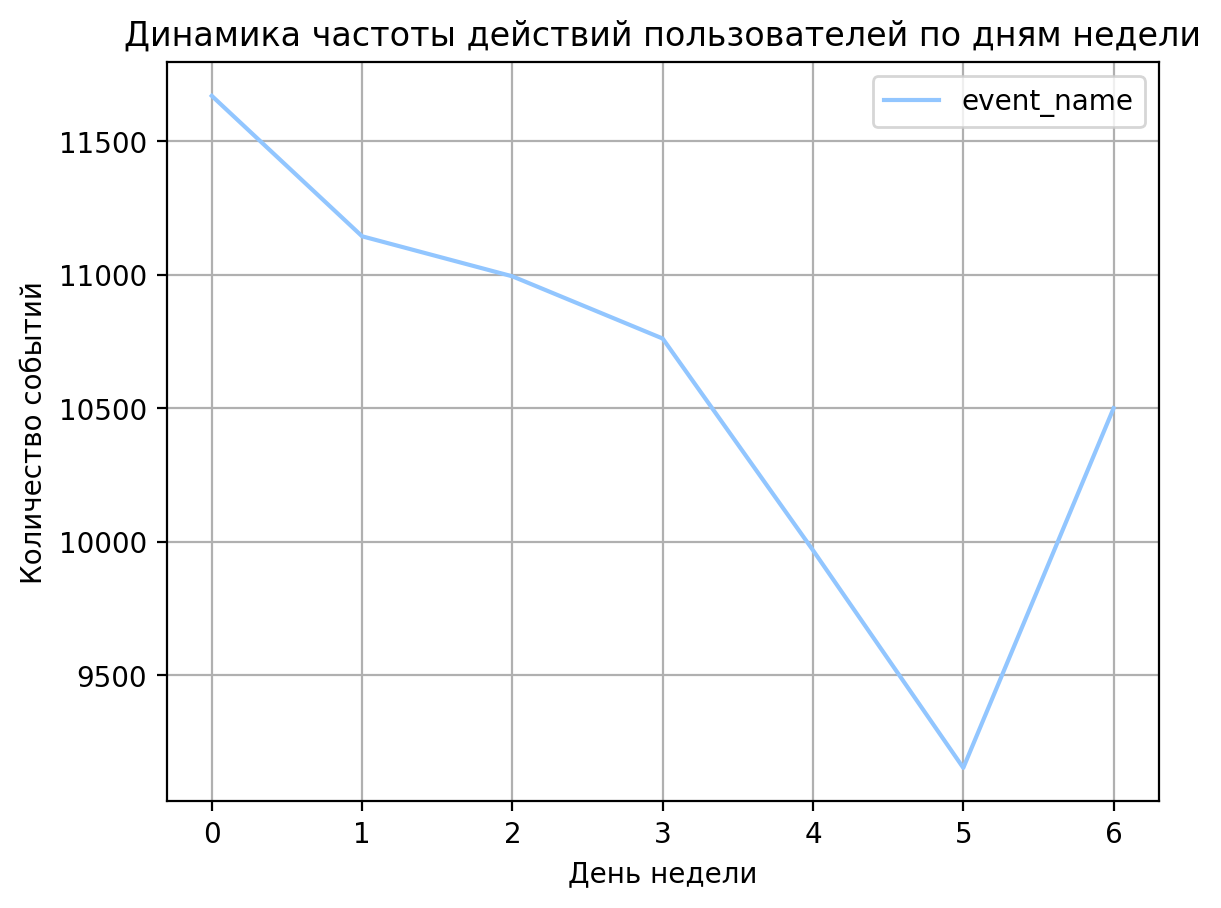

In [23]:
mobile_dataset['day_of_week'] = mobile_dataset['event_time'].dt.weekday

mobile_dataset.pivot_table(index='day_of_week', values='event_name', aggfunc='count').plot(grid=True)
plt.title('Динамика частоты действий пользователей по дням недели') 
plt.xlabel("День недели")
plt.ylabel("Количество событий")
plt.show()

Пользователи ведут себя активнее в будние дни, к пятнице активность снижается, а в воскресенье снова вырастает.

### Конверсия в целевое действие — просмотр контактов

In [24]:
#найдем количество пользователей, совершивших целевое действие

contacts_show = mobile_dataset.query('event_name == "contacts_show"')
contacts_show_users = contacts_show['user_id'].nunique()

#посчитаем всех уникальных пользователей

all_users = mobile_dataset['user_id'].nunique()

#рассчитаем конверсию

convertion = contacts_show_users/all_users
print(contacts_show_users)
print(all_users)
print(f'Конверсия в просмотр контактов: {convertion:.2%}')

981
4293
Конверсия в просмотр контактов: 22.85%


Проанализировав данные за 4 недели, мы выяснили, что удержание пользователей с недельным горизонтом анализа максимально 17% на второй день, а на седьмой составляет около 5-6%. 

Среднее время сессии пользователя около 16 минут. 

Есть нулевые сессии около 20%, самое популярное событие среди таких сессий это - пользователь увидел рекоменованное объявление. Есть аномально долгие сессии, но у 90% пользователей максимальное время в приложении не превышает часа. 

В среднем на пользователя приходится 2 сессии. 

Наиболее частое событие это tips_show — пользователь увидел рекомендованные объявления, что не удивительно, также довольно много событий типа photos_show — просмотр фотографий, advert_open — открытие карточки объявления и различный поиск - search. 

Целевое событие - просмотр контактов чаще совершается по будням, чем по выходным дням и в целом пользователи ведут себя активнее в будние дни, к пятнице активность снижается, а в воскресенье снова вырастает.

Конверсия в целевое действие - просмотр контактов равна 22,85%.

## Сегментация пользователей по времени, проведенному в приложении

Для управления вовлеченностью (адаптировать приложение под целевую и смежные аудитории) будет полезно исследовать группы пользователей, отличающиеся по времени проведенному в приложении и выяснить у кого выше удержание и конверсия: у пользователей, которые много времени зависают в приложении или кто все делает быстро?

Сегментируем пользователей на 3 группы:

- пользователи, которые проводят в приложении мало времени, до 15 минут;
- пользователи, которые проводят в приложении среднее количество времени, от 15 до 30 минут;
- пользователи, которые проводят в приложении много времени, более 30 минут;

In [25]:
#рассчитаем для каждого пользователя среднее время, проведенное в приложении

avgerage_time = session.groupby('user_id').agg({'session_duration': 'mean'}).reset_index()
avgerage_time

user_id  session_duration
0     0001b1d5-b74a-4cbf-aeb0-7df5947bf349         11.502321
1     00157779-810c-4498-9e05-a1e9e3cedf93         32.706135
2     00463033-5717-4bf1-91b4-09183923b9df         24.707917
3     004690c3-5a84-4bb7-a8af-e0c8f8fca64e         18.456552
4     00551e79-152e-4441-9cf7-565d7eb04090          3.109247
...                                    ...               ...
4288  ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07         24.710207
4289  ffc01466-fdb1-4460-ae94-e800f52eb136          0.868974
4290  ffcf50d9-293c-4254-8243-4890b030b238          1.339636
4291  ffe68f10-e48e-470e-be9b-eeb93128ff1a         12.958839
4292  fffb9e79-b927-4dbb-9b48-7fd09b23a62b         18.306884

[4293 rows x 2 columns]

In [26]:
#напишем функцию для выделения групп пользователей по среднему времени, проведенному в приложении

def group(session_duration):
    if session_duration <= 15:
        return 'fast'
    elif 15 < session_duration <= 30:
        return 'mean'
    else:
        return 'long'
    
#добавим столбец с ипнформацией о группе

avgerage_time['group'] = avgerage_time['session_duration'].apply(group)
avgerage_time['group'].value_counts()

fast    2742
mean     909
long     642
Name: group, dtype: int64

### Проверка на пересечение пользователей в группах

In [27]:
#проверим не попали ли какие-то пользователи в несколько групп сразу

avgerage_time.groupby('user_id').agg({'group': 'nunique'}).query('group > 1')

Empty DataFrame
Columns: [group]
Index: []

Пользователи не пересекаются

### Проверка размеров выборок

In [28]:
avgerage_time.groupby('group').agg({'user_id': 'nunique'})

user_id
group         
fast      2742
long       642
mean       909

### Пользователи какой группы часто возвращаются в мобильное приложение (retention rate)

In [29]:
#выделим данные по 3м группам

session_fast = avgerage_time.query('group == "fast"')
session_mean = avgerage_time.query('group == "mean"')
session_long = avgerage_time.query('group == "long"')

list1 = session_fast['user_id'].tolist()
mobile_dataset_fast = mobile_dataset.query('user_id in @list1')

list2 = session_mean['user_id'].tolist()
mobile_dataset_mean = mobile_dataset.query('user_id in @list2')

list3 = session_long['user_id'].tolist()
mobile_dataset_long = mobile_dataset.query('user_id in @list3')

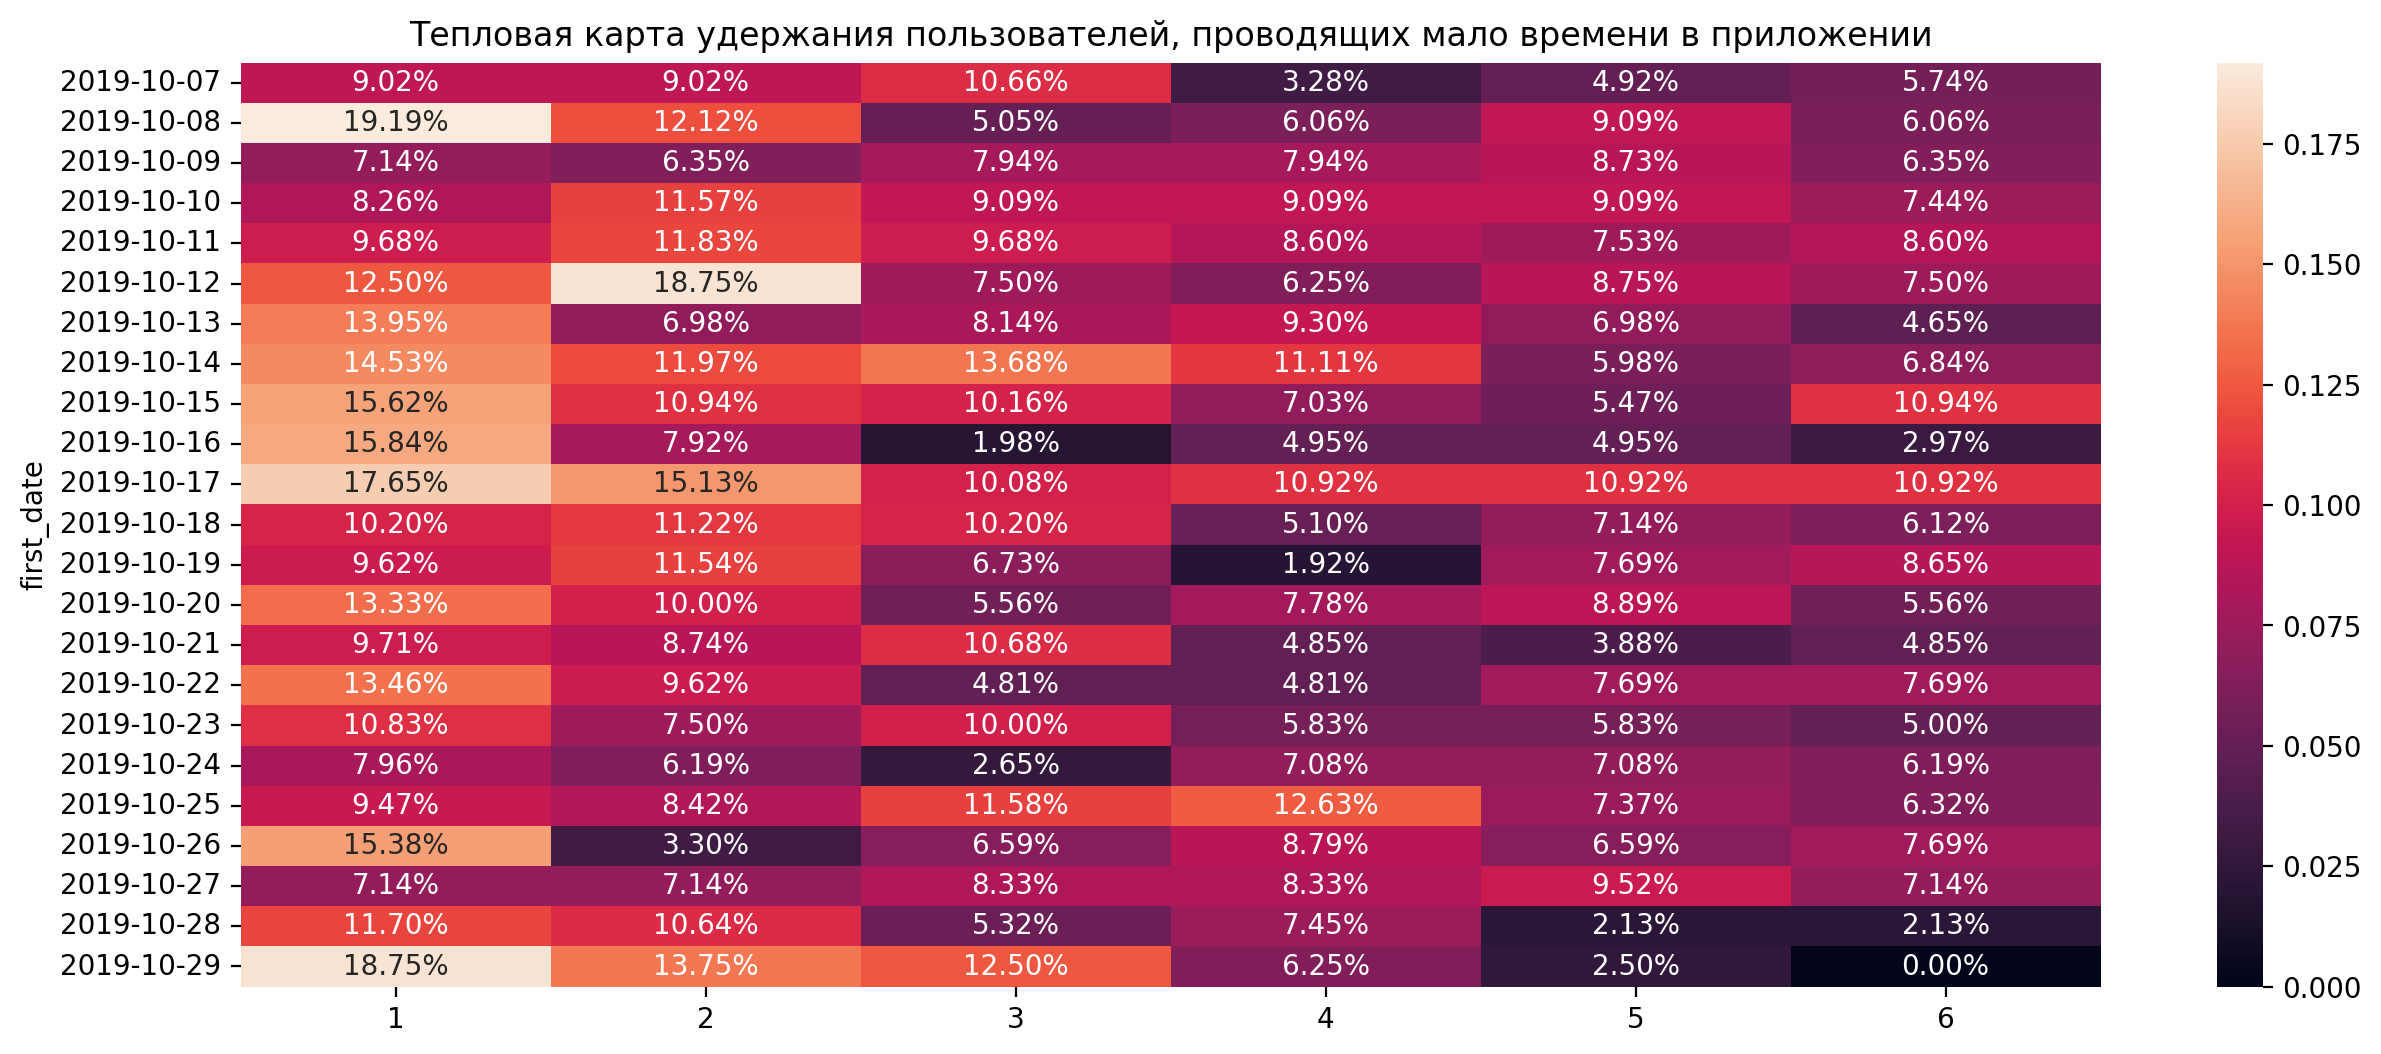

In [30]:
#построим хитмэп с учётом горизонта анализа 7 дней

retention_raw, retention = get_retention(
    mobile_dataset_fast, session_start, datetime(2019, 11, 4).date(), 7
)

plt.figure(figsize = (15, 6))  
sns.heatmap(retention.drop(columns = ['cohort_size', 0]), #удаляем размеры когорт и 0 столбец
            annot = True,  
            fmt = '.2%'  
           )
plt.title('Тепловая карта удержания пользователей, проводящих мало времени в приложении')  
plt.show()

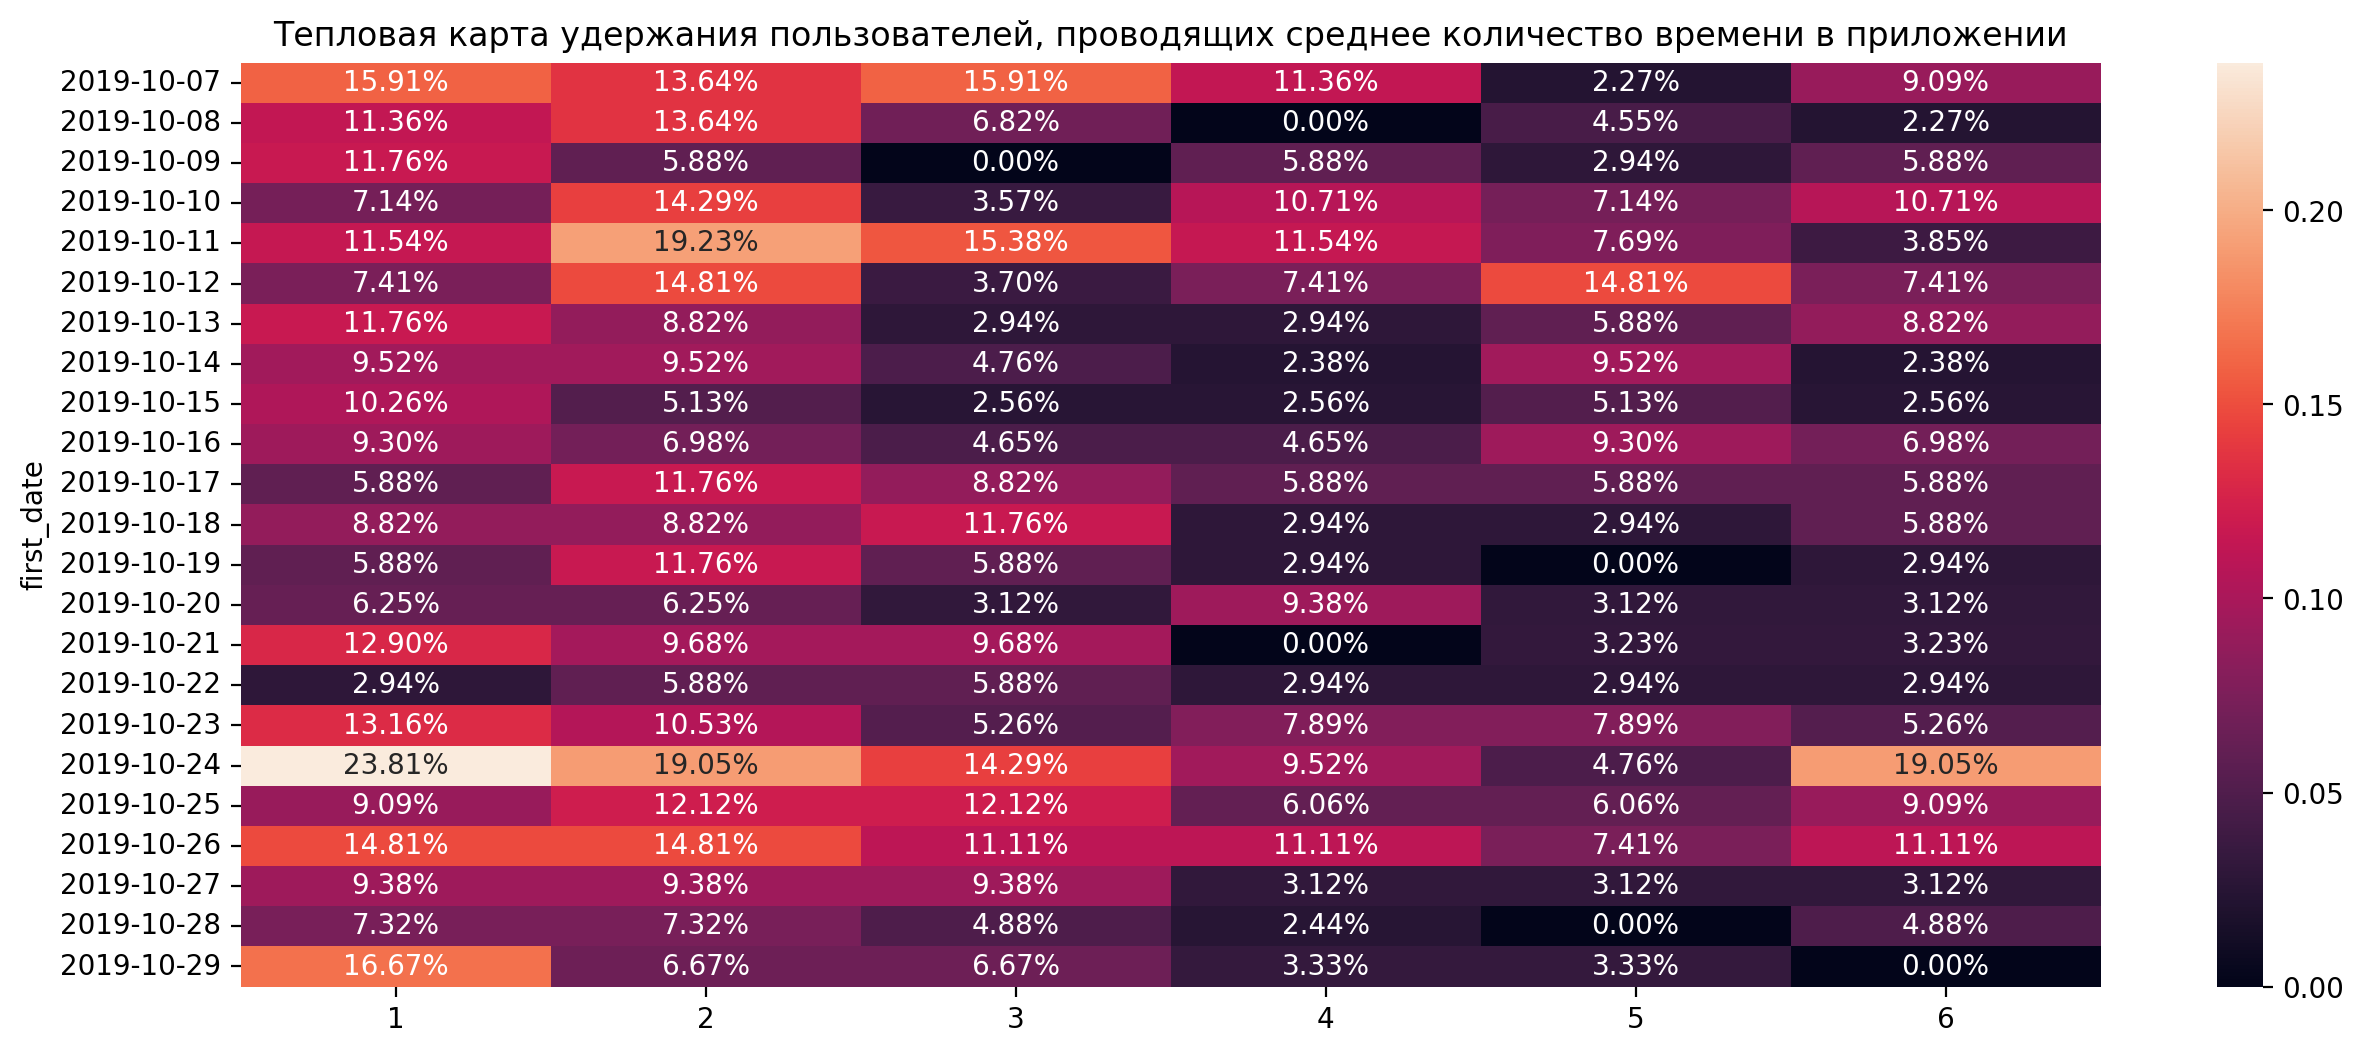

In [31]:
#построим хитмэп с учётом горизонта анализа 7 дней

retention_raw, retention = get_retention(
    mobile_dataset_mean, session_start, datetime(2019, 11, 4).date(), 7
)

plt.figure(figsize = (15, 6))  
sns.heatmap(retention.drop(columns = ['cohort_size', 0]), #удаляем размеры когорт и 0 столбец
            annot = True,  
            fmt = '.2%'  
           )
plt.title('Тепловая карта удержания пользователей, проводящих среднее количество времени в приложении')  
plt.show()

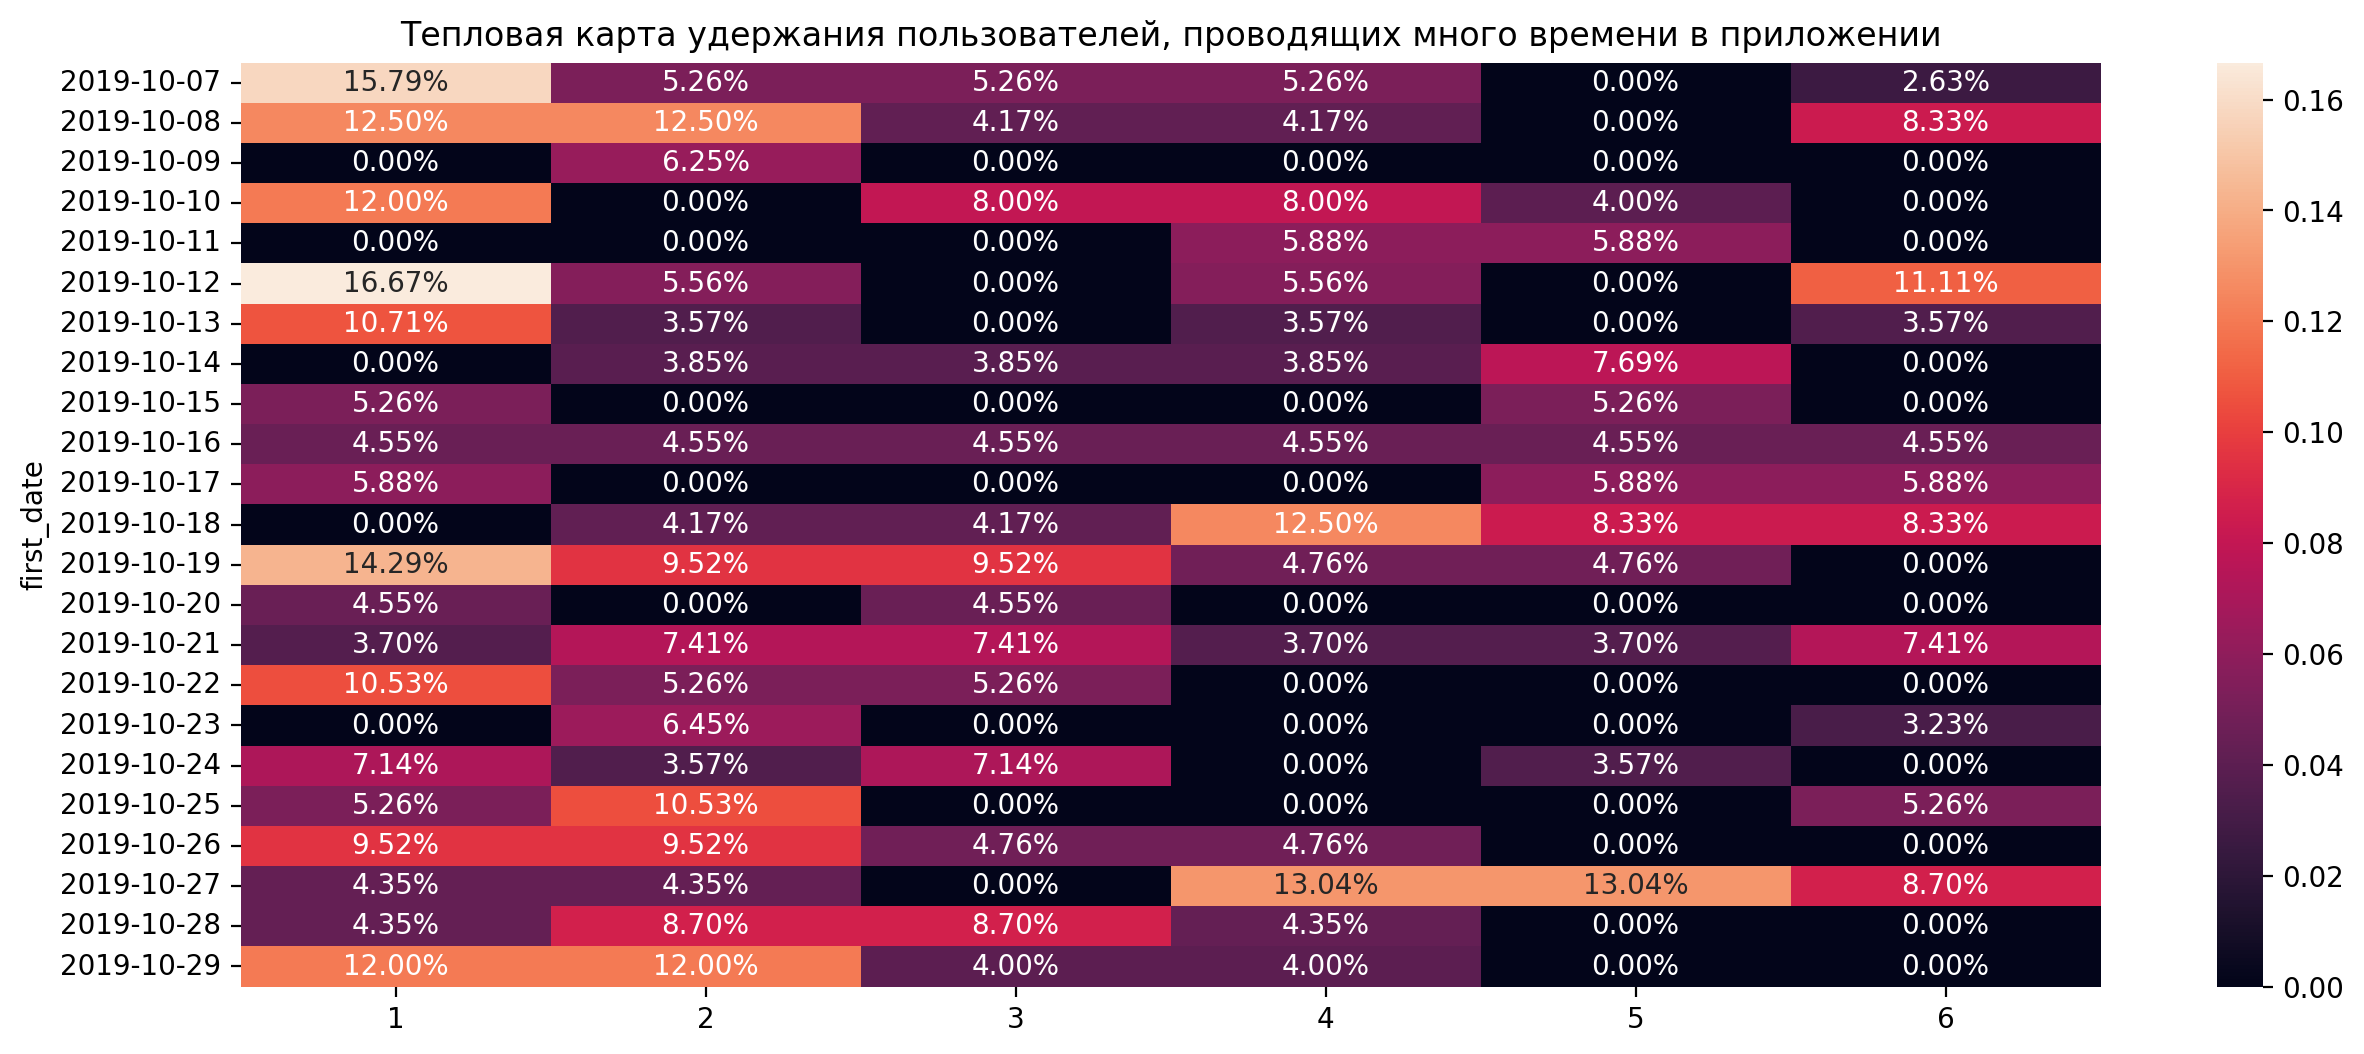

In [32]:
#построим хитмэп с учётом горизонта анализа 7 дней

retention_raw, retention = get_retention(
    mobile_dataset_long, session_start, datetime(2019, 11, 4).date(), 7
)

plt.figure(figsize = (15, 6))  
sns.heatmap(retention.drop(columns = ['cohort_size', 0]), #удаляем размеры когорт и 0 столбец
            annot = True,  
            fmt = '.2%'  
           )
plt.title('Тепловая карта удержания пользователей, проводящих много времени в приложении')  
plt.show()

Таким образом, retantion rate выше для пользователей, проводящих в приложении до 15 минут, чуть ниже для пользователей, проводящих в приложении от 15 до 30 минут и ниже всего для тех кто проводит в приложении свыше 30 минут.

### Пользователи какой группы часто совершают целевое событие (конверсия в просмотры контактов)

In [33]:
#найдем количество пользователей, совершивших целевое действие по группе fast

contacts_show_fast = mobile_dataset_fast.query('event_name == "contacts_show"')
contacts_show_users_fast = contacts_show_fast['user_id'].nunique()

#посчитаем всех уникальных пользователей

all_users_fast = mobile_dataset_fast['user_id'].nunique()

#рассчитаем конверсию

convertion1 = contacts_show_users_fast/all_users_fast

print(contacts_show_users_fast)
print(all_users_fast)
print(f'Конверсия в просмотр контактов пользователей, проводящих мало времени в приложении : {convertion1:.2%}')

584
2742
Конверсия в просмотр контактов пользователей, проводящих мало времени в приложении : 21.30%


In [34]:
#найдем количество пользователей, совершивших целевое действие по группе mean

contacts_show_mean = mobile_dataset_mean.query('event_name == "contacts_show"')
contacts_show_users_mean = contacts_show_mean['user_id'].nunique()

#посчитаем всех уникальных пользователей

all_users_mean = mobile_dataset_mean['user_id'].nunique()

#рассчитаем конверсию

convertion2 = contacts_show_users_mean/all_users_mean

print(contacts_show_users_mean)
print(all_users_mean)

print(f'Конверсия в просмотр контактов пользователей, проводящих среднее количество времени в приложении : {convertion2:.2%}')

222
909
Конверсия в просмотр контактов пользователей, проводящих среднее количество времени в приложении : 24.42%


In [35]:
#найдем количество пользователей, совершивших целевое действие по группе long

contacts_show_long = mobile_dataset_long.query('event_name == "contacts_show"')
contacts_show_users_long = contacts_show_long['user_id'].nunique()

#посчитаем всех уникальных пользователей

all_users_long = mobile_dataset_long['user_id'].nunique()

#рассчитаем конверсию

convertion3 = contacts_show_users_long/all_users_long

print(contacts_show_users_long)
print(all_users_long)

print(f'Конверсия в просмотр контактов пользователей, проводящих много времени в приложении : {convertion3:.2%}')

175
642
Конверсия в просмотр контактов пользователей, проводящих много времени в приложении : 27.26%


**Вывод:** лучшую конверсию в просмотр контактов демонстрируют пользователи, проводящие в приложении более 30 минут.

## Проверка гипотез

In [36]:
#объединим датасеты mobile_dataset и mobile_sourсes

mobile_dataset = mobile_dataset.merge(
        mobile_sourсes[['user_id', 'source']], on='user_id', how='left'
    )
mobile_dataset

event_time     event_name  \
0     2019-10-07 13:39:45.989359      tips_show   
1     2019-10-07 13:40:31.052909      tips_show   
2     2019-10-07 13:41:05.722489      tips_show   
3     2019-10-07 13:43:20.735461      tips_show   
4     2019-10-07 13:45:30.917502      tips_show   
...                          ...            ...   
74192 2019-11-03 15:51:23.959572      tips_show   
74193 2019-11-03 15:51:57.899997  contacts_show   
74194 2019-11-03 16:07:40.932077      tips_show   
74195 2019-11-03 16:08:18.202734      tips_show   
74196 2019-11-03 16:08:25.388712      tips_show   

                                    user_id  session_id  \
0      0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1   
1      0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1   
2      0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1   
3      0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1   
4      0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1   
...                                     ...         ...   
74192  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10029   
74193  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10029   
74194  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10029   
74195  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10029   
74196  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10029   

                 first_date_time  first_date  event_date  day_of_week  source  
0     2019-10-07 13:39:45.989359  2019-10-07  2019-10-07            0   other  
1     2019-10-07 13:39:45.989359  2019-10-07  2019-10-07            0   other  
2     2019-10-07 13:39:45.989359  2019-10-07  2019-10-07            0   other  
3     2019-10-07 13:39:45.989359  2019-10-07  2019-10-07            0   other  
4     2019-10-07 13:39:45.989359  2019-10-07  2019-10-07            0   other  
...                          ...         ...         ...          ...     ...  
74192 2019-10-12 00:57:21.241896  2019-10-12  2019-11-03            6  google  
74193 2019-10-12 00:57:21.241896  2019-10-12  2019-11-03            6  google  
74194 2019-10-12 00:57:21.241896  2019-10-12  2019-11-03            6  google  
74195 2019-10-12 00:57:21.241896  2019-10-12  2019-11-03            6  google  
74196 2019-10-12 00:57:21.241896  2019-10-12  2019-11-03            6  google  

[74197 rows x 9 columns]

### Пользователи, установившие приложение по ссылке из yandex, и пользователи, установившие приложение по ссылке из google, демонстрируют разную конверсию в просмотры контактов

H_0: Конверсия пользователей, установивших приложение по ссылке из google и конверсия пользователей, установивших приложение по ссылке из yandex, равны

H_1: Конверсии пользователей, установивших приложение из google и из yandex различаются

In [37]:
users_source = mobile_dataset.query('source != "other"').groupby('source').agg({'user_id': 'nunique'})
users_source.columns = ['all_users']
users_source

all_users
source           
google       1129
yandex       1934

In [38]:
users_target_action = (mobile_dataset.query('source != "other" and event_name == "contacts_show"')).pivot_table(index='source', values = 'user_id', aggfunc = 'nunique')
users_target_action.columns = ['target_action']
users_target_action

target_action
source               
google            275
yandex            478

In [39]:
#напишем функцию, которая принимает в качестве аргументов 4 числа для z-теста пропорций 
#(пользователи в группах и по событиям), плюс альфа

def z_test(successes1, successes2, trials1, trials2, alpha):
    
    alpha = .05 # критический уровень статистической значимости
    
    # пропорция успехов в первой группе:
    p1 = successes1/trials1
    
    # пропорция успехов во второй группе:
    p2 = successes2/trials2
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [40]:
z_test(users_target_action['target_action'][0],
      users_target_action['target_action'][1],
      users_source['all_users'][0],
      users_source['all_users'][1],
      alpha = 0.05)

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Пользователи, которые проводят мало времени в приложении и пользователи, которые проводят много времени в приложении не различаются по частоте действий

Приведены два датасета: количество действий в день пользователей, которые проводят мало времени в приложении, и тех, кто проводит много времени в приложении. Проверим гипотезу о равенстве количества действий, которые совершают пользователи обеих групп.

In [41]:
events_fast = mobile_dataset_fast.groupby('event_date').agg({'event_name':'count'})
events_fast = events_fast['event_name'].tolist()

In [42]:
events_long = mobile_dataset_long.groupby('event_date').agg({'event_name':'count'})
events_long = events_long['event_name'].tolist()

In [43]:
alpha = 0.05 

results = st.ttest_ind(events_fast, events_long, equal_var = False) 

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.25092856220793e-06
Отвергаем нулевую гипотезу


Вывод: Если бы частота действий пользователей, проводящих мало и много времени в приложении была бы равна, то можно было бы предположить, что интерфейс приложения не так удобен и пользователю, пробывшему 
в приложении мало времени, но совершившему столько же действий, сколько и пользователь, пробывший много времени в приложении, оно просто не понравилось в использовании и он его покинул. 

Но результаты теста говорят об обратном - частота действий пользователей, проводящих в приложении мало и много времени различаются, скорее всего чем больше пользователь проводит времени в приложении, тем в среднем большее количество действий он совершает.

## Выводы и рекомендации

Проведя анализ данных о событиях, совершенных в мобильном приложении "Ненужные вещи", мы пришли к **следующим выводам:**

- удержание пользователей при недельном горизонте анализа, максимально 17% на второй день, а на седьмой день составляет около 5-6%;
- среднее время сессии пользователя около 16 минут;
- довольно большой процент нулевых сессий - 1934 (около 20%), самое популярное событие среди таких сессий это - пользователь увидел рекоменованное объявление и очевидно закрыл приложение;
- у 90% пользователей максимальное время в приложении не превышает часа;
- в среднем на пользователя приходится 2 сессии;
- наиболее частое событие это tips_show — пользователь увидел рекомендованные объявления, что не удивительно, также довольно много событий типа photos_show — просмотр фотографий, advert_open — открытие карточки объявления и различный поиск - search; 
- целевое событие - просмотр контактов чаще совершается по будням, чем по выходным дням;
- пользователи ведут себя активнее в будние дни, к пятнице активность снижается, а в воскресенье снова вырастает;
- конверсия в просмотр контактов: 22.85%.

Для управления вовлеченностью мы **сегментировали пользователей** на основе их поведения на **3 группы:**

- пользователи, которые проводят в приложении мало времени, до 15 минут;
- пользователи, которые проводят в приложении среднее количество времени, от 15 до 30 минут;
- пользователи, которые проводят в приложении много времени, более 30 минут;

И выяснили, что **retantion rate выше для пользователей, проводящих в приложении в среднем до 15 минут**, чуть ниже для пользователей, проводящих в приложении от 15 до 30 минут и ниже всего для тех кто проводит в приложении в среднем свыше 30 минут.

А также, что **лучшую конверсию в просмотр контактов демонстрируют пользователи, проводящие в приложении в среднем более 30 минут**, чуть ниже пользователи со средним временем сессии от 15 до 30 минут и ниже всего пользователи, сидящие в приложении менее 15 минут.

Возможно, что пользователи с более низкой конверсией (сидящие в приложении в среднем менее 15 минут) не нашли подходящего объявления и поэтому чаще возвращаются, а пользователи с высокой конверсией (проводящие в приложении более 30 минут) достигли своей цели и коэффициент удержания у них ниже в пределах рассматримоего периода (4 недели).

Далее мы проверили **гипотезу** о том, что пользователи, установившие приложение по ссылке из **yandex**, и пользователи, установившие приложение по ссылке из **google**, демонстрируют разную конверсию в просмотры контактов. Результат теста показал что, нет оснований считать доли разными, таким образом, **источник привлечения не влияет на конверсию в целевое действие**.

И наконец, мы предположили, что пользователи, которые проводят мало времени в приложении и пользователи, которые проводят много времени в приложении не различаются по частоте действий, однако результаты теста говорят об обратном. **Частота действий пользователей, проводящих в приложении мало и много времени различаются**, скорее всего чем больше пользователь проводит времени в приложении, тем в среднем большее количество действий он совершает.

Для улучшения приложения с точки зрения пользовательского опыта можно показывать не одно рекомендованное объявление, а подборку нескольких. Увидев одно объявление и поняв что оно не подходящее пользователь не остается в приложении. А для того чтобы посмотреть подборку пользователь возможно зайдет и останется в приложении на какое-то время. 

В целом интерфейс приложения необходимо адаптировать для пользователей, которые проводят в приложении в среднем до 15 и от 15 до 30 минут (большая часть, а их конверсия меньше чем для пользователей со средним временем сессии свыше 30 минут), чтобы они могли быстро находить подходящее объявление и совершать целевое действие в просмотр контактов.